In [ ]:
import torch
from torchtext import data
from torchtext import datasets
import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
import os

os.chdir("/drive/MyDrive/inflation_reports") 
os.getcwd()

'/drive/MyDrive/inflation_reports'

In [ ]:
path = "/drive/MyDrive/inflation_reports/dataset/data.csv"
df = pd.read_csv(path, encoding='latin-1')

In [ ]:
def to_sentiment(rating):

  if rating == 'negative':
    return 0
  elif rating == 'neutral':
    return 1
  elif rating == 'positive':
    return 2

df['score'] = df.sentiment.apply(to_sentiment)

In [ ]:
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42

df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
train_sentences = list(df_train['sentence'].values)
train_labels = list(df_train['score'].values)

dev_sentences = list(df_test['sentence'].values)
dev_labels = list(df_test['score'].values)

In [ ]:
!pip install -qq transformers

import transformers
from transformers import BertModel, BertTokenizer, AdamW

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict = False)

In [ ]:
#choose max_length for bert model based on the input length

max_length = 0
list_len=[]
for sentence in train_sentences:
    #print(sentence)
    length = len(tokenizer.tokenize(sentence))
    list_len.append(length)
    
from collections import Counter
Counter(list_len).most_common(100)

[(26, 141),
 (25, 137),
 (22, 133),
 (23, 131),
 (24, 123),
 (18, 119),
 (28, 119),
 (20, 118),
 (21, 115),
 (15, 113),
 (27, 111),
 (19, 109),
 (16, 107),
 (17, 107),
 (30, 103),
 (29, 100),
 (31, 98),
 (32, 96),
 (14, 95),
 (33, 88),
 (35, 82),
 (12, 82),
 (34, 81),
 (13, 80),
 (39, 65),
 (38, 63),
 (36, 62),
 (40, 57),
 (10, 56),
 (37, 56),
 (41, 53),
 (11, 51),
 (45, 50),
 (42, 48),
 (50, 46),
 (46, 44),
 (48, 44),
 (47, 43),
 (43, 39),
 (49, 35),
 (51, 35),
 (44, 27),
 (54, 26),
 (55, 25),
 (8, 25),
 (57, 22),
 (9, 21),
 (56, 20),
 (52, 18),
 (59, 18),
 (7, 18),
 (53, 18),
 (61, 17),
 (58, 16),
 (6, 14),
 (66, 14),
 (62, 14),
 (64, 14),
 (65, 12),
 (68, 11),
 (60, 11),
 (69, 11),
 (63, 10),
 (70, 9),
 (5, 6),
 (72, 5),
 (77, 5),
 (67, 5),
 (71, 4),
 (76, 4),
 (4, 3),
 (74, 3),
 (73, 2),
 (75, 2),
 (79, 1),
 (80, 1),
 (96, 1),
 (3, 1),
 (98, 1),
 (109, 1),
 (90, 1),
 (83, 1),
 (92, 1),
 (153, 1),
 (122, 1)]

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(train_labels)
encoded_labels = le.transform(train_labels)
encoded_test_labels = le.transform(dev_labels)

In [ ]:
def encoder_generator(sentences,labels):
    
    sent_index = []
    input_ids = []
    attention_masks =[]

    for index,sent in enumerate(sentences):
        
        sent_index.append(index)
        
        encoded_dict = tokenizer.encode_plus(sent,
                                             add_special_tokens=True,
                                             max_length=500,
                                             pad_to_max_length=True,
                                             truncation = True,
                                             return_attention_mask=True,
                                             return_tensors='pt')
        input_ids.append(encoded_dict['input_ids'])

        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids,dim=0)
    attention_masks = torch.cat(attention_masks,dim=0)
    labels = torch.tensor(labels)
    sent_index = torch.tensor(sent_index)

    return sent_index,input_ids,attention_masks,labels

train_sent_index,train_input_ids,train_attention_masks,train_encoded_label_tensors = encoder_generator(train_sentences,encoded_labels)
dev_sent_index,dev_input_ids,dev_attention_masks,dev_encoded_label_tensors = encoder_generator(dev_sentences,encoded_test_labels)
print('Original: ', train_sentences[0])
print('Token IDs:', train_input_ids[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  In Russia , Raisio 's Food Division 's home market stretches all the way to Vladivostok .
Token IDs: tensor([  101,  1130,  2733,   117, 20089, 23652,   112,   188,  6702,  1784,
          112,   188,  1313,  2319, 14664,  1155,  1103,  1236,  1106, 20868,
        15435, 12223,  1377,   119,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  

In [ ]:
from torch.utils.data import TensorDataset,random_split

train_dataset = TensorDataset(train_input_ids,train_attention_masks,train_encoded_label_tensors)
dev_dataset = TensorDataset(dev_input_ids,dev_attention_masks,dev_encoded_label_tensors)


print('train data samples is {}'.format(len(train_dataset)))
print("valid data samples is {}".format(len(dev_dataset)))

train data samples is 3876
valid data samples is 970


In [ ]:
from torch.utils.data import DataLoader,RandomSampler,SequentialSampler

bs=4

train_data_loader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=bs)
valid_data_loader = DataLoader(dev_dataset,
                              sampler=RandomSampler(dev_dataset),
                              batch_size=bs)

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict = False)
bert_model = bert_model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.fc_input = nn.Linear(embedding_dim,embedding_dim)
        
        self.conv_0 = nn.Conv1d(in_channels = embedding_dim, 
                                out_channels = n_filters, 
                                kernel_size = filter_sizes[0])
        
        self.conv_1 = nn.Conv1d(in_channels = embedding_dim, 
                                out_channels = n_filters, 
                                kernel_size = filter_sizes[1])
        
        self.conv_2 = nn.Conv1d(in_channels = embedding_dim, 
                                out_channels = n_filters, 
                                kernel_size = filter_sizes[2])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, encoded):
                
        #embedded = [batch size, sent len, emb dim]
        embedded = self.fc_input(encoded)
        #print(embedded.shape)
        
        embedded = embedded.permute(0, 2, 1)
        #print(embedded.shape)
        
        #embedded = [batch size, emb dim, sent len]
        
        conved_0 = F.relu(self.conv_0(embedded))
        conved_1 = F.relu(self.conv_1(embedded))
        conved_2 = F.relu(self.conv_2(embedded))
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        #pooled_n = [batch size, n_fibatlters]
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        result =  self.fc(cat)
        
        #print(result.shape)
        
        return result

In [ ]:
EMBEDDING_DIM = 768
N_FILTERS = 100
FILTER_SIZES = [2,3,5]
OUTPUT_DIM = len(le.classes_)
DROPOUT = 0.3
PAD_IDX = tokenizer.pad_token_id

cnn = CNN(EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
cnn = cnn.to(device)

TypeError: ignored

In [ ]:
import torch.optim as optim

model_prameters = list(bert_model.parameters())+list(cnn.parameters())

optimizer = optim.Adam(model_prameters,lr=2e-5,eps=1e-8)

criterion = nn.CrossEntropyLoss()

criterion = criterion.to(device)

In [ ]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]]).cuda()

In [ ]:
from tqdm import tqdm

def train():
    
    epoch_loss = 0
    epoch_acc = 0
    
    bert_model.train()
    cnn.train()
    
    for batch in tqdm(train_data_loader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        optimizer.zero_grad()
        
        embedded = bert_model(b_input_ids,b_input_mask)[0]
        
        predictions = cnn(embedded)
        #print(predictions.shape)
        #print(b_labels.shape)
        
        loss = criterion(predictions, b_labels)
        
        acc = categorical_accuracy(predictions, b_labels)
        #print(acc)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(train_data_loader), epoch_acc / len(train_data_loader)

In [ ]:
import numpy as np

def predictions_labels(preds,labels):
    pred = np.argmax(preds,axis=1).flatten()
    label = labels.flatten()
    return pred,label

In [ ]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
def eval():
    epoch_loss = 0
    
    total_predictions = []
    total_true = []
    
    all_true_labels = []
    all_pred_labels = []
    
    bert_model.eval()
    cnn.eval()
    
    with torch.no_grad():
    
        for batch in tqdm(valid_data_loader):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            embedded = bert_model(b_input_ids,b_input_mask)[0]
            predictions = cnn(embedded)
            #print(predictions.shape)
            #print(b_labels.shape)

            loss = criterion(predictions, b_labels)
            epoch_loss += loss.item()
            
            predictions = predictions.detach().cpu().numpy()

            label_ids = b_labels.to('cpu').numpy()
    
            pred,true = predictions_labels(predictions,label_ids)
        
            all_pred_labels.extend(pred)
            all_true_labels.extend(true)

    print(classification_report(all_pred_labels,all_true_labels))
    avg_val_accuracy = accuracy_score(all_pred_labels,all_true_labels)
    macro_f1_score = f1_score(all_pred_labels,all_true_labels,average='macro')
    
    avg_val_loss = epoch_loss/len(valid_data_loader)

    print("accuracy = {0:.2f}".format(avg_val_accuracy))
            
    return avg_val_loss,avg_val_accuracy,macro_f1_score

In [ ]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
from collections import defaultdict
epochs = 10

best_macro_f1 = float('0')

history = defaultdict(list)

for epoch in range(epochs):
    
    start_time = time.time()
    train_loss,train_acc = train()
    valid_loss,valid_acc,macro_f1 = eval()
    end_time = time.time()
    
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(valid_acc.item())
    history['val_loss'].append(valid_loss)

100%|██████████| 243/243 [00:18<00:00, 13.31it/s]


              precision    recall  f1-score   support

           0       0.84      0.79      0.81       116
           1       0.87      0.91      0.89       544
           2       0.84      0.78      0.81       310

    accuracy                           0.86       970
   macro avg       0.85      0.83      0.84       970
weighted avg       0.85      0.86      0.85       970

accuracy = 0.86
Epoch: 01 | Epoch Time: 4m 14s
	Train Loss: 0.524 | Train Acc: 78.41%
	 Val. Loss: 0.365 |  Val. Acc: 85.57%


100%|██████████| 243/243 [00:18<00:00, 13.33it/s]


              precision    recall  f1-score   support

           0       0.89      0.80      0.84       123
           1       0.82      0.92      0.87       512
           2       0.85      0.73      0.79       335

    accuracy                           0.84       970
   macro avg       0.85      0.82      0.83       970
weighted avg       0.84      0.84      0.84       970

accuracy = 0.84
Epoch: 02 | Epoch Time: 4m 14s
	Train Loss: 0.260 | Train Acc: 90.40%
	 Val. Loss: 0.391 |  Val. Acc: 83.81%


100%|██████████| 243/243 [00:18<00:00, 13.32it/s]


              precision    recall  f1-score   support

           0       0.86      0.81      0.83       118
           1       0.89      0.91      0.90       559
           2       0.83      0.82      0.82       293

    accuracy                           0.87       970
   macro avg       0.86      0.84      0.85       970
weighted avg       0.87      0.87      0.87       970

accuracy = 0.87
Epoch: 03 | Epoch Time: 4m 14s
	Train Loss: 0.130 | Train Acc: 95.72%
	 Val. Loss: 0.409 |  Val. Acc: 86.60%


100%|██████████| 243/243 [00:18<00:00, 13.35it/s]


              precision    recall  f1-score   support

           0       0.87      0.83      0.85       116
           1       0.91      0.89      0.90       584
           2       0.79      0.84      0.82       270

    accuracy                           0.87       970
   macro avg       0.86      0.85      0.85       970
weighted avg       0.87      0.87      0.87       970

accuracy = 0.87
Epoch: 04 | Epoch Time: 4m 14s
	Train Loss: 0.092 | Train Acc: 97.14%
	 Val. Loss: 0.427 |  Val. Acc: 86.80%


100%|██████████| 243/243 [00:18<00:00, 13.31it/s]


              precision    recall  f1-score   support

           0       0.80      0.85      0.83       103
           1       0.96      0.81      0.88       675
           2       0.62      0.93      0.74       192

    accuracy                           0.84       970
   macro avg       0.79      0.87      0.82       970
weighted avg       0.88      0.84      0.85       970

accuracy = 0.84
Epoch: 05 | Epoch Time: 4m 14s
	Train Loss: 0.064 | Train Acc: 98.07%
	 Val. Loss: 0.760 |  Val. Acc: 84.12%


100%|██████████| 243/243 [00:18<00:00, 13.27it/s]


              precision    recall  f1-score   support

           0       0.73      0.93      0.82        86
           1       0.94      0.86      0.89       623
           2       0.77      0.85      0.81       261

    accuracy                           0.86       970
   macro avg       0.81      0.88      0.84       970
weighted avg       0.87      0.86      0.86       970

accuracy = 0.86
Epoch: 06 | Epoch Time: 4m 14s
	Train Loss: 0.055 | Train Acc: 98.12%
	 Val. Loss: 0.574 |  Val. Acc: 86.19%


100%|██████████| 243/243 [00:18<00:00, 13.28it/s]


              precision    recall  f1-score   support

           0       0.75      0.88      0.81        94
           1       0.91      0.86      0.89       606
           2       0.76      0.81      0.79       270

    accuracy                           0.85       970
   macro avg       0.81      0.85      0.83       970
weighted avg       0.86      0.85      0.85       970

accuracy = 0.85
Epoch: 07 | Epoch Time: 4m 14s
	Train Loss: 0.041 | Train Acc: 98.81%
	 Val. Loss: 0.613 |  Val. Acc: 84.95%


100%|██████████| 243/243 [00:18<00:00, 13.33it/s]


              precision    recall  f1-score   support

           0       0.80      0.88      0.84       100
           1       0.93      0.86      0.90       616
           2       0.76      0.87      0.81       254

    accuracy                           0.87       970
   macro avg       0.83      0.87      0.85       970
weighted avg       0.87      0.87      0.87       970

accuracy = 0.87
Epoch: 08 | Epoch Time: 4m 14s
	Train Loss: 0.037 | Train Acc: 98.76%
	 Val. Loss: 0.551 |  Val. Acc: 86.60%


100%|██████████| 243/243 [00:18<00:00, 13.33it/s]


              precision    recall  f1-score   support

           0       0.81      0.87      0.84       102
           1       0.87      0.90      0.89       554
           2       0.84      0.77      0.81       314

    accuracy                           0.86       970
   macro avg       0.84      0.85      0.84       970
weighted avg       0.86      0.86      0.85       970

accuracy = 0.86
Epoch: 09 | Epoch Time: 4m 14s
	Train Loss: 0.031 | Train Acc: 99.02%
	 Val. Loss: 0.661 |  Val. Acc: 85.57%


100%|██████████| 243/243 [00:18<00:00, 13.36it/s]


              precision    recall  f1-score   support

           0       0.85      0.79      0.82       117
           1       0.91      0.89      0.90       584
           2       0.79      0.85      0.82       269

    accuracy                           0.87       970
   macro avg       0.85      0.84      0.85       970
weighted avg       0.87      0.87      0.87       970

accuracy = 0.87
Epoch: 10 | Epoch Time: 4m 13s
	Train Loss: 0.042 | Train Acc: 98.66%
	 Val. Loss: 0.630 |  Val. Acc: 86.70%


[0.7840557275541795, 0.9040247678018576, 0.957172342621259, 0.9713622291021672, 0.9806501547987616, 0.9811661506707946, 0.9881320949432405, 0.9876160990712074, 0.9901960784313726, 0.9865841073271414]
[0.8556701030927835, 0.8381443298969072, 0.865979381443299, 0.8680412371134021, 0.8412371134020619, 0.8618556701030928, 0.8494845360824742, 0.865979381443299, 0.8556701030927835, 0.8670103092783505]
tensor([0.7841, 0.9040, 0.9572, 0.9714, 0.9807, 0.9812, 0.9881, 0.9876, 0.9902,
        0.9866])


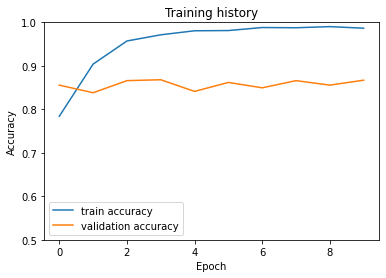

In [ ]:
import matplotlib.pyplot as plt
print(history['train_acc'])
print(history['val_acc'])

new_tensor = torch.tensor(history['train_acc'], device = 'cpu')
print(new_tensor)

plt.plot(new_tensor, label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);